In [1]:
import biotite.sequence.io.fasta as fasta
import biotite.application.muscle as muscle
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as plt
import sys

sys.path.append('..')
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from modules.utils import find_fully_conserved_windows, get_consensus_motif, get_rna_consensus_motif

Save sequence names and sequences to lists

In [ ]:
fasta_file = fasta.FastaFile.read('./clk.fasta')
seqs = fasta.get_sequences(fasta_file)

list_of_seqs = []
list_of_names = []
for key, value in seqs.items():
    list_of_seqs.append(value)
    list_of_names.append(key)

Align the sequence with Muscle

In [ ]:
app = muscle.Muscle5App(list_of_seqs)
app.start()
app.join()
alignment = app.get_alignment()

gapped_seqs = alignment.get_gapped_sequences()
for i in range(len(gapped_seqs)):
    print(list_of_names[i], " " * 3, gapped_seqs[i])

CLK2 chr1:155268287-155269328 strand=-     AGGGCCCT-----------------------------------------------------------------------------------GGATCTGCTTTGGAGAT--------------------GG----------ATGG---GCACGGAGCATTTGTGACCCCCA-GTGCTCTCCCTGGCATGTTGGGCTTATTGTGTTGG-------------GAGCAGCTTCTCCGCCC---------------CAGCGGCCTCCAC-----------------------------------------------------------------------------------------------------------------------------------------TCTTTAATGGGGACCTTGCTTGTGAACTGCCTTTTTCC--CCCAAGCCCTGGGCTC------TGTAGCCCCCTTGGCAGGCGGGCTTGGGTGGGGGCAAGGGGAGATCTGTGT------CTGCCC-----------GGAAGGGCATTGTGTAGAGCATGG-----------------------GGTTGTGGGTG-----------ACATTGGCAACAACACCACTTCTCTGCTCTGCCCATGCCTCTCCCTGTTCCTGTTTTGGGTTTGGGGACTTG----------------------------------------GGATTATGCGCCGCTCTCTCTTCTCACACCGATCCACCTTACTGCA-------------------------------------------------------------------------------------------------------------------TCTGACGTGTTCCCTTCCACTGTCCCCCATCATCG---TCTGTCCCCCCTGGCTG---GGCGCCTGTGACC-------

Save tha alignment to visualise somewhere (for example, Jalview)

In [ ]:
fasta_file = fasta.FastaFile()
fasta.set_alignment(fasta_file, alignment, seq_names=list_of_names)
fasta_file.write("./aligment_biotite.fasta")

Visualise alignemnt with biotite

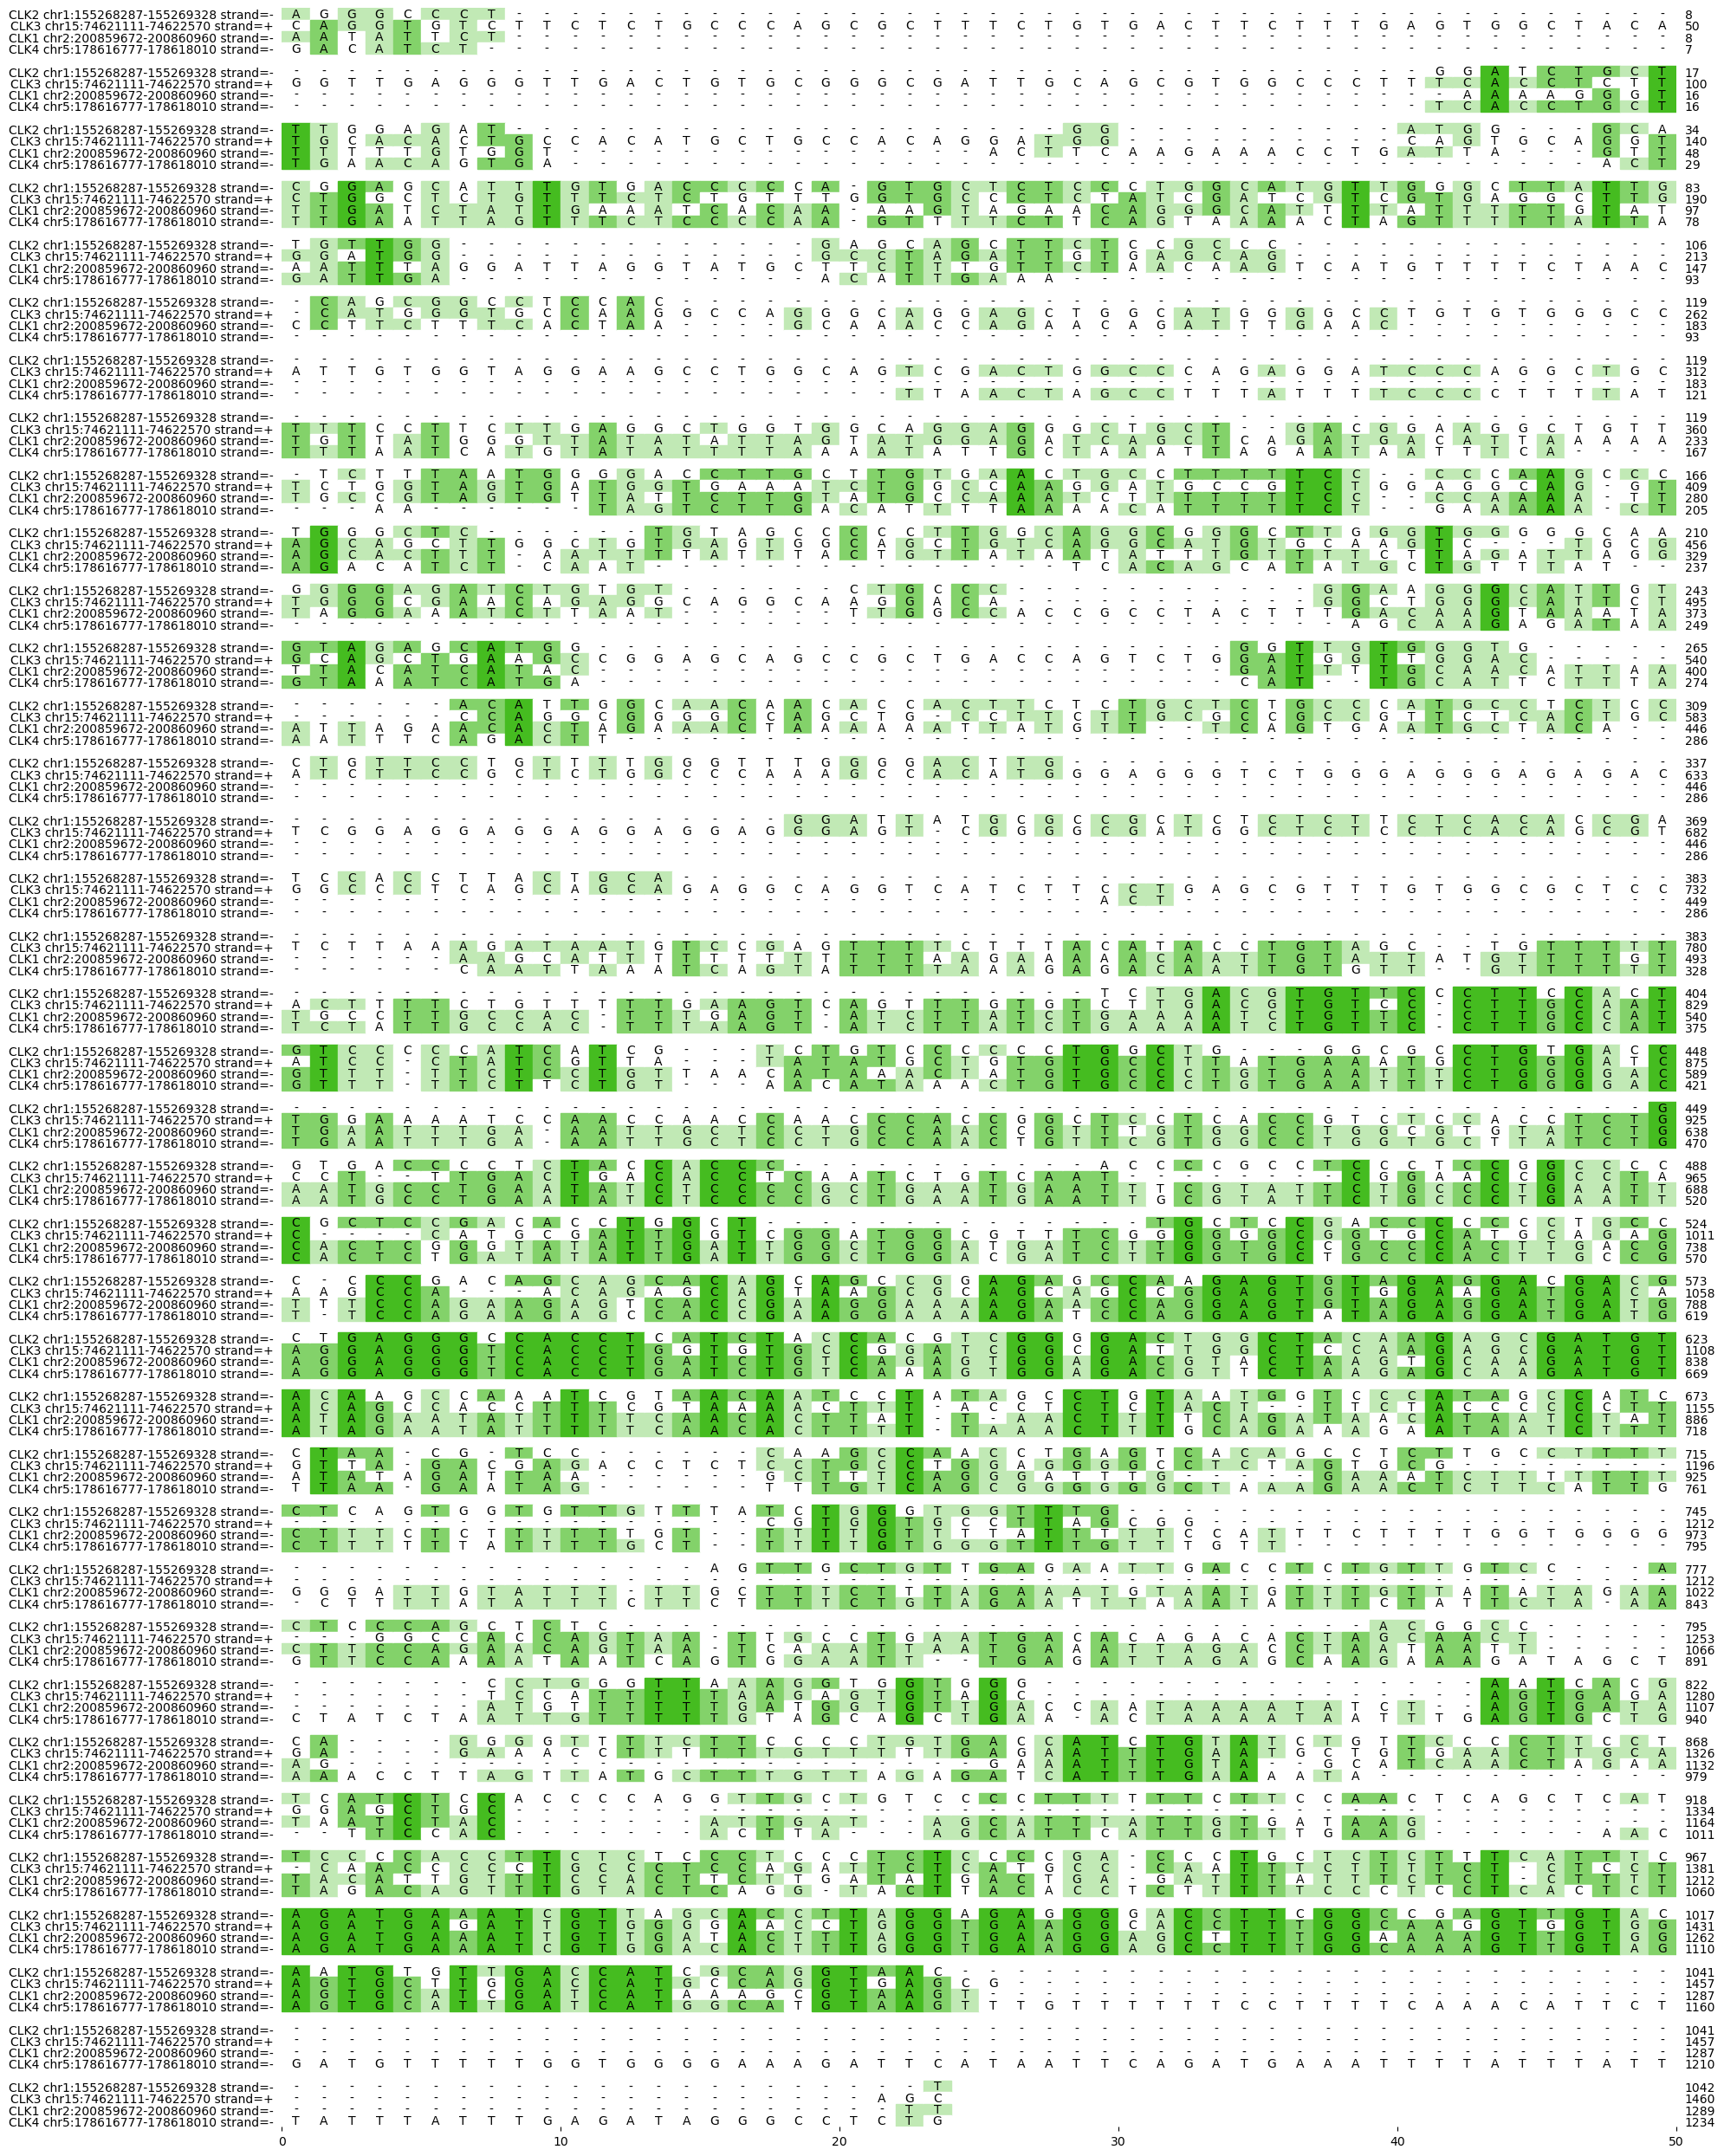

In [5]:
fig = plt.figure(figsize=(20.0, 25.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax,
    alignment,
    labels=list_of_names,
    show_numbers=True,
    show_line_position=True,
)
fig.tight_layout()

plt.show()

Get again the alignment that was saved

In [ ]:
alignment = AlignIO.read("./aligment_biotite.fasta", "fasta")

Using a sliding window we go through the sequences and look for conservative sections

In [ ]:
size_window = 21
# Find conserved windows of specified size with average conservation score
windows = find_fully_conserved_windows(alignment, window=size_window, threshold=0.8)

aligment_motifs = {}
subalignment_ = MultipleSeqAlignment([])

for idx, (start, end) in enumerate(windows): # Iterate over each conserved window
    subalignment = MultipleSeqAlignment([])

    all_subseqs = []
    for record in alignment:
        subseq = record.seq[start-1:end].transcribe()  # -1 т.к. индексация с 0 + Т на U надо поменять
        subalignment.append(SeqRecord(subseq, id=record.id, description=f"{start}-{end}"))
        subalignment_.append(SeqRecord(subseq, id=rf"{record.id}-{start}-{end}", description=''))
        all_subseqs.append(subseq) # Collect the RNA subsequence
    aligment_motifs[f"{record.id}-{start}-{end}"] = all_subseqs # Store all RNA subsequences from this window, using the last record's ID

AlignIO.write(subalignment_, f"./conserved_windows_all_{size_window}nt.fasta", "fasta")

1

From conservative sequnces, we get motifs that can be searched in databases or articles 

In [ ]:
with open("./consensus_motifs.txt", "w") as f:
    for key, values in aligment_motifs.items():
        motif = get_rna_consensus_motif(values) # From sequnces get motif
        f.write(f"{key}: {motif}\n")